In [2]:
from groq import Groq
from langchain_groq import ChatGroq
import os

from dotenv import load_dotenv
load_dotenv()



True

In [21]:
llm = ChatGroq(temperature=0,
                      model_name="meta-llama/llama-4-scout-17b-16e-instruct",
                      api_key=os.environ.get("GROQ_API_KEY"))
                      

# llm.invoke("What is up")


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain_cohere import CohereEmbeddings
embeddings = CohereEmbeddings(model="embed-english-v3.0")

In [9]:
import ssl
import certifi
from langchain.document_loaders import WebBaseLoader
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import requests

# Disable SSL warnings (use this with caution)
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Create a custom SSL context that doesn't verify certificates
ssl_context = ssl.create_default_context(cafile=certifi.where())
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

# Use the custom SSL context with WebBaseLoader
urls = ['https://copyright.gov.in/Copyright_Rules_2013/chapter_i.html',
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_ii.html', 
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_iii.html', 
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_iv.html', 
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_v.html', 
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_vi.html', 
     'https://copyright.gov.in/Copyright_Rules_2013/chapter_vii.html',
      'https://copyright.gov.in/Copyright_Rules_2013/chapter_viii.html',
       'https://copyright.gov.in/Copyright_Rules_2013/chapter_ix.html', 
       'https://copyright.gov.in/Copyright_Rules_2013/chapter_x.html', 
       'https://copyright.gov.in/Copyright_Rules_2013/chapter_xi.html', 
       'https://copyright.gov.in/Copyright_Rules_2013/chapter_xii.html', 
       'https://copyright.gov.in/Copyright_Rules_2013/chapter_xiii.html',
        'https://copyright.gov.in/Copyright_Rules_2013/chapter_xiv.html', 
        'https://copyright.gov.in/Copyright_Rules_2013/chapter_xv.html', 
        'https://copyright.gov.in/Copyright_Rules_2013/chapter_xvi.html', 
        'https://copyright.gov.in/Copyright_Rules_2013/chapter_xvii.html',
         'https://copyright.gov.in/Copyright_Rules_2013/chapter_xviii.html']

docs = []
for url in urls:
    loader = WebBaseLoader(url)
    loader.requests_kwargs = {'verify': False}  # Bypass SSL verification
    docs.append(loader.load())

docs_list = [item for sublist in docs for item in sublist]



In [11]:
docs_list


[Document(metadata={'source': 'https://copyright.gov.in/Copyright_Rules_2013/chapter_i.html', 'title': ' CHAPTER I ', 'language': 'No language found.'}, page_content='\n\n\n\n\n\n CHAPTER I \n\n\n\n\n\n\n\nTHE COPYRIGHT RULES, 2013\nCHAPTER I\nCHAPTER II\nCHAPTER III\nCHAPTER IV\nCHAPTER V\nCHAPTER VI\nCHAPTER VII\nCHAPTER VIII\nCHAPTER IX\nCHAPTER X\nCHAPTER XI\nCHAPTER XII\nCHAPTER XIII\nCHAPTER XIV\nCHAPTER XV\nCHAPTER XVI\nCHAPTER XVII\nCHAPTER XVIII\nFIRST SCHEDULE\nSECOND SCHEDULE\n\n\n\nCHAPTER I\n\n\n\n\n\n\n \n\nThe\r\r\n\t\t\tCopyright Rules, 20131 \n\n\n\nIn exercise of power conferred\r\r\n\t\t\tby section 78 of the Copyright Act, 1957, and \r\r\n\t\t\tin supersession of the Copyright Rules, 1958, except as respect things\r\r\n\t\t\tdone or omitted to be done before such supersession, the Central Government hereby\r\r\n\t\t\tmakes the following Rules, namely:—\n\n\nCHAPTER\r\r\n\t\t\tI\nPRELIMINARY\n\n\n\n1.\r\r\n\t\t\t\tShort title, extent and commencement.—(1) These rules

In [12]:
# Split documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=100)
split_docs = text_splitter.split_documents(docs_list)

# Clean up the page content by removing escape characters
for i, doc in enumerate(split_docs):
    # Replace common escape characters
    cleaned_text = doc.page_content.replace('\n', ' ').replace('\r', '').replace('\t', ' ')
    # Replace multiple spaces with a single space
    cleaned_text = ' '.join(cleaned_text.split())
    split_docs[i].page_content = cleaned_text

print(f"Number of documents after splitting: {len(split_docs)}")
if split_docs:
    print(f"Sample of cleaned text: {split_docs[0].page_content[:200]}...")

Number of documents after splitting: 352
Sample of cleaned text: CHAPTER I THE COPYRIGHT RULES, 2013 CHAPTER I CHAPTER II CHAPTER III CHAPTER IV CHAPTER V CHAPTER VI CHAPTER VII CHAPTER VIII CHAPTER IX CHAPTER X CHAPTER XI CHAPTER XII CHAPTER XIII CHAPTER XIV CHAPT...


In [ ]:
vectorstore = Chroma.from_documents(documents=split_docs,
                                    embedding=embeddings,
                                    collection_name="full-context",
                                    persist_directory="vector")
                                    


In [19]:
retriever = vectorstore.as_retriever()

In [15]:
import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on copyright i.e Introduction to the Copyright Act, 1957, The Copyright (Amendment) Act, 2012, Reasons for Amendments, Digital Protection, Internet Service Provider (ISP) Liability, Statutory Licenses, Royalty Rights, Performer Rights, Copyright Societies, Exceptions for the Physically Disabled. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

router_llm = ChatGroq(temperature=0,
                      model_name="llama3-8b-8192",
                      api_key=os.environ.get("GROQ_API_KEY"))
start = time.time()
question_router = prompt | router_llm | JsonOutputParser()
#
question = "What is copyright law?"
print(question_router.invoke({"question": question}))
end = time.time()
print(f"The time required to generate response by Router Chain in seconds:{end - start}")

{'datasource': 'vectorstore'}
The time required to generate response by Router Chain in seconds:0.7913682460784912


In [23]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Try to give as much information as possible.
    c <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
start = time.time()
rag_chain = prompt | llm | StrOutputParser()

In [22]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)


start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()
question = "Copyright laws and application"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

{'score': 'yes'}
The time required to generate response by the retrieval grader in seconds:1.0388028621673584


In [24]:
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()




In [25]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
answer_grader = prompt | llm | JsonOutputParser()

In [27]:
prompt_intent = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a classifier assessing whether the query given is just asking a
    question based on the context or if it is giving a command. Give either 'command' or 'question_answering' to indicate whether
    the given query by the user. Provide the intent output in a single key 'intent' and no preamble or explanation.  <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question/query:
    \n\n
    {question}
    \n\n
    """,
    input_variables=["question"],
)

intent_classifier = prompt_intent | llm | JsonOutputParser()


In [28]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)


In [29]:
from typing_extensions import TypedDict
from typing import List, Dict, Any
### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str] = []
    context: int # this is the user id
    user_data: Dict[str, Any]
    form_struct: Dict[str, Any]
    

In [30]:
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
             filtered_docs.append(d)
        # Document not relevant
        else:
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
#
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    question = state["question"]
    # Initialize documents as empty list if it doesn't exist
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents:
        documents.append(web_results.page_content)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

In [31]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """


    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
         return "websearch"
    elif source['datasource'] == 'vectorstore':
        return "vectorstore"

In [32]:
def route_intent(state):
    question = state["question"]
    classification = intent_classifier.invoke({"question": question})
    return classification

In [33]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """


    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query

        return "websearch"
    else:
        # We have relevant documents, so generate answer

        return "generate"

In [34]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            return "useful"
        else:
            return "not useful"
    else:
        return "not supported"

In [35]:
def entry_data(state):
    """
    This node doesn't modify the state - it simply passes it through without changes.
    This can be useful for debugging or as a placeholder in the workflow.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): The unchanged state
    """
    print("This goes as an entry for parallel action of getting user data and form data")
    return state

In [36]:
def user_data_sql(state):
    # Get user data
    user_data = {}
    return {"user_data": user_data}
    

In [37]:
def get_form_struct(state):
    # form data from RAG

    form_struct = {}
    return {"form_struct": form_struct}

In [38]:
def merge_node(state):
    # Takes keys from user_data and adds it to form struct
    new_form_stuct = {
        "name": "sidhant"
    }
    return {"form_struct": new_form_stuct}

In [42]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) 
workflow.add_node("entry_data", entry_data)
workflow.add_node("user_data_sql", user_data_sql)
workflow.add_node("get_form_struct", get_form_struct)
workflow.add_node("merge_node", merge_node)
workflow.add_node("route_intent", route_intent)



In [43]:
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)



workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": "route_intent",  # Now this points to a valid node
        "not useful": "websearch",
    },
)

workflow.add_conditional_edges(
    "route_intent",
    lambda x: x["intent"],  # Use the output of the route_intent function
    {
        "question_answering": END,
        "command": "entry_data"
    }
)
workflow.add_edge("entry_data", "user_data_sql")
workflow.add_edge("entry_data", "get_form_struct")
workflow.add_edge("user_data_sql", "merge_node")
workflow.add_edge("get_form_struct", "merge_node")
workflow.add_edge("merge_node", END)

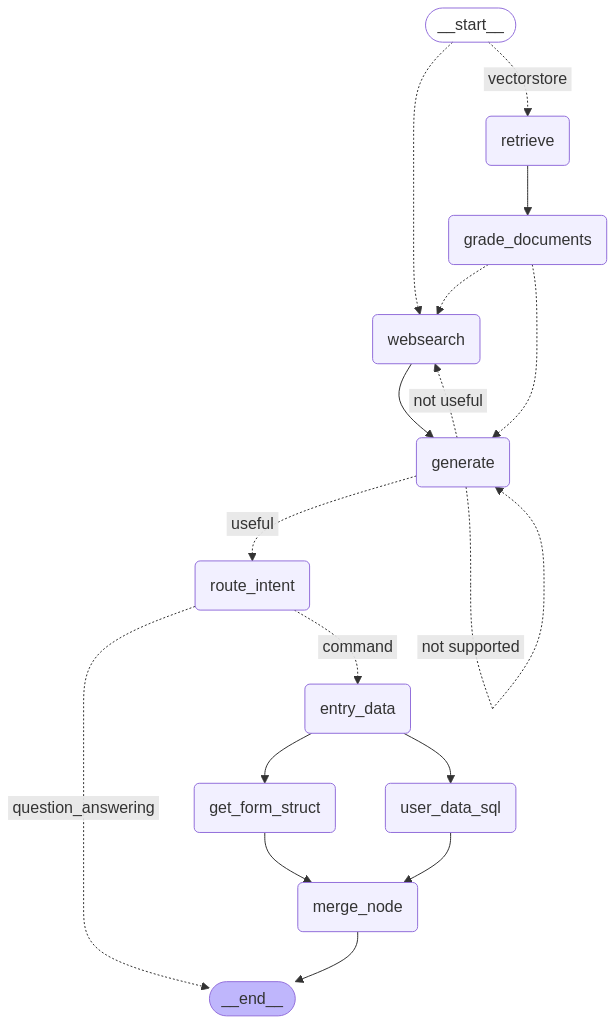

In [58]:
from IPython.display import display, Image
app = workflow.compile()
# display(Image(app.get_graph().draw_mermaid()))
Image(app.get_graph().draw_mermaid_png())

In [11]:
import json

def flatten_form_data(json_response):
    """
    Takes a JSON response containing form data and flattens it to a simplified structure.
    
    Args:
        json_response: JSON data containing form structure
        
    Returns:
        dict: Flattened form data structure
    """
    data = json_response if isinstance(json_response, dict) else json.loads(json_response)
    
    # Create flattened structure
    flattened_data = {
        "formId": data["data"]["formId"],
        "formTitle": data["data"]["title"],
        "formDescription": data["data"]["description"]
    }
    
    # Add each field with empty values
    for field in data["data"]["fields"]:
        flattened_data[field["label"]] = ""
    
    return flattened_data



with open('data.json', 'r') as file:
    json_data = json.load(file)

flattened = flatten_form_data(json_data)

# Save to a file if needed
with open('data_processed.json', 'w') as output_file:
    json.dump(flattened, output_file, indent=2)

print("JSON flattened successfully")

JSON flattened successfully


In [115]:
from langchain_community.vectorstores import Chroma
from langchain_cohere import CohereEmbeddings
from langchain_core.documents import Document
import json

# Initialize embedding model and vector store
embedding_model = CohereEmbeddings(model="embed-english-v3.0")

def store_form_data(json_data):
    """
    Store form data in the vector database
    
    Args:
        json_data: JSON data containing form structure
        
    Returns:
        str: Status message
    """
    # Extract title and description for embedding
    title = json_data["data"]["title"]
    description = json_data["data"]["description"]
    
    # Create Document objects
    documents = [
        Document(page_content=title, metadata={"source": "title", "full_data": json.dumps(json_data)}),
        Document(page_content=description, metadata={"source": "description", "full_data": json.dumps(json_data)})
    ]
    
    # Add to vector store
    vectorstore = Chroma.from_documents(
        documents=documents,
        embedding=embedding_model,
        collection_name="form-struct-data",
        persist_directory="vector"
    )
    vectorstore.persist()
    
    return "Form data stored successfully in vector database"

def query_form_data(query_text, n_results=1):
    """
    Query the vector database for similar form data
    
    Args:
        query_text: The query text to search for
        n_results: Number of results to return
        
    Returns:
        list: Retrieved form data
    """
    # Initialize the vector store
    vectorstore = Chroma(
        embedding_function=embedding_model,
        collection_name="form-struct-data",
        persist_directory="vector"
    )
    
    # Search the vector store
    results = vectorstore.similarity_search(query_text, k=n_results)
    
    # Extract and return the JSON data
    retrieved_data = []
    for doc in results:
        try:
            # Parse the JSON from metadata
            full_data = json.loads(doc.metadata["full_data"])
            retrieved_data.append({
                "data": full_data
            })
        except Exception as e:
            retrieved_data.append({"error": str(e), "content": doc.page_content})
    
    return retrieved_data

def process_and_store_json_file(file_path):
    """
    Load JSON data from a file, process it, and store it in the vector database
    
    Args:
        file_path: Path to the JSON file
        
    Returns:
        str: Status message
    """
    try:
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        
        result = store_form_data(json_data)
        return result
    except Exception as e:
        return f"Error processing file: {str(e)}"


# Process and store form data from the json_data variable that's already loaded
# result = store_form_data(json_data)
# print(result)

# Load data from data.json
try:
    with open('data.json', 'r') as file:
        json_data = json.load(file)
    
    # Process and store the original form data
    result = store_form_data(json_data)
    print(result)
    
    # Check if flattened data is already available
except Exception as e:
    
    print(f"Error loading or processing data: {str(e)}")

# Example query to retrieve the form data
query_result = query_form_data("copyright registration form")
print(f"Found {len(query_result)} matching forms")
query_result


Form data stored successfully in vector database
Found 1 matching forms


[{'data': {'message': 'Form data retrieved successfully for ML processing.',
   'data': {'formId': 1,
    'title': 'FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT [SEE RULE 70]',
    'description': '\n    FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT\n    For applying to the Registrar of Copyrights, Copyright Office, New Delhi\n    for registration of copyright in accordance with section 45 of the Copyright Act, 1957 (14 of 1957).\n  ',
    'metadata': {'createdAt': '2025-03-23T07:44:42.225Z',
     'updatedAt': '2025-03-23T07:44:42.225Z'},
    'fields': [{'id': 1,
      'label': 'name',
      'description': 'Full name of the applicant',
      'type': 'TEXT',
      'required': True,
      'validations': {'maxLength': 200, 'minLength': 3},
      'order': 1},
     {'id': 2,
      'label': 'address',
      'description': 'Complete address of the applicant',
      'type': 'TEXTAREA',
      'required': True,
      'validations': {'maxLength': 500, 'minLength': 10},
      'order'

In [14]:
query_result = query_form_data("copyright")
print(f"Retrieved {len(query_result)} forms matching the query")


Retrieved 0 forms matching the query


In [28]:
def flatten_form_data(json_response):
    """
    Takes a JSON response containing form data and flattens it to a simplified structure.

    Args:
        json_response: JSON data containing form structure

    Returns:
        dict: Flattened form data structure
    """
    if isinstance(json_response, dict):
        data = json_response
    elif isinstance(json_response, list):
        data = json_response[0] if json_response else {}
    else:
        data = json.loads(json_response)

    # Create flattened structure
    data = data["data"]
    flattened_data = {
        "formId": data["data"]["formId"],
        "formTitle": data["data"]["title"],
        "formDescription": data["data"]["description"],
    }

    # Add each field with empty values
    for field in data["data"]["fields"]:
        flattened_data[field["label"]] = ""

    return flattened_data

flatten_form_data(m)

{'formId': 1,
 'formTitle': 'FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT [SEE RULE 70]',
 'formDescription': '\n    FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT\n    For applying to the Registrar of Copyrights, Copyright Office, New Delhi\n    for registration of copyright in accordance with section 45 of the Copyright Act, 1957 (14 of 1957).\n  ',
 'Applicant Name': '',
 'Applicant Address': '',
 'Applicant Nationality': '',
 'Applicant Category': '',
 'Work Title': '',
 'Work Description': '',
 'Work Class': '',
 'Work Language': '',
 'Author Name': '',
 'Author Address': '',
 'Publication Status': '',
 'Publisher Details': '',
 'Year of First Publication': '',
 'Fee Payment Details': '',
 'Declaration': '',
 'Work Sample': ''}

In [36]:
import os
from dotenv import load_dotenv
import requests
import json
load_dotenv()

BACKEND_URL = os.environ.get("BACKEND_URL")

def get_user_profile(user_id):
    """
    Fetch user profile information from the backend API.
    
    Args:
        user_id: User ID to fetch profile for
        
    Returns:
        dict: User profile data or error message
    """
    try:
        # Construct the full URL for the API request
        url = f"{BACKEND_URL}/ml/profile/{user_id}"
        
        # Set headers including any required authentication
        headers = {
            "Content-Type": "application/json",
        }
        
        # Make the API request
        response = requests.get(url, headers=headers)
        
        # Check if the request was successful
        if response.status_code == 200:
            return response.json()
        else:
            return {
                "error": True,
                "message": f"Failed to fetch user profile: {response.status_code}",
                "status_code": response.status_code
            }
    except Exception as e:
        return {
            "error": True,
            "message": f"Exception occurred: {str(e)}",
        }

# Example usage
user_id = 2  # Define user_id before using it
user_data = get_user_profile(user_id)
print(json.dumps(user_data, indent=2))

{
  "name": "Admin User",
  "email": "dmtosarvesh@gmail.com",
  "position": "Administrator",
  "department": "Legal"
}


In [73]:
def fill_form_with_user_data(form_info, user_data):
    """
    A general-purpose function that fills empty fields in a form with matching values 
    from user data, relying only on direct key matches.
    
    Args:
        form_info (dict): The form dictionary with possibly empty values
        user_data (dict): The user data dictionary to extract values from
    
    Returns:
        dict: The updated form with filled values where possible
    """
    # Create a copy of the form to avoid modifying the original
    updated_form = form_info.copy()
    
    # For each key in the form
    for key in updated_form:
        # Check if the form field is empty (empty string)
        if updated_form[key] == "":
            # Check if there's a matching key in user_data
            if key in user_data:
                # Fill the form field with the user data value
                updated_form[key] = user_data[key]
    
    return updated_form


user_data = {
    'name': 'Admin', 
    'email': 'dmtosarvesh@gmail.com', 
    'position': 'Administrator', 
    'department': 'Legal', 
    'role': 'Admin', 
    'description': 'Administrator role',
    'address': "My house"
}

form_info = {
    "formId": 1, 
    "formTitle": "FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT [SEE RULE 70]", 
    "formDescription": "\n    FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT\n    For applying to the Registrar of Copyrights, Copyright Office, New Delhi\n    for registration of copyright in accordance with section 45 of the Copyright Act, 1957 (14 of 1957).\n  ", 
    "name": "", 
    "address": "", 
    "nationality": "", 
    "category": "", 
    "work_title": "", 
    "work_description": "", 
    "work_class": "", 
    "work_language": "", 
    "author_name": "", 
    "author_address": "", 
    "publication_status": "", 
    "publisher_details": "", 
    "publication_year": "", 
    "fee_payment_details": "", 
    "declaration": "", 
    "work_sample": ""
}

# Fill the form with user data
updated_form = fill_form_with_user_data(form_info, user_data)

# Print the updated form
import json
print(json.dumps(updated_form, indent=2))

{
  "formId": 1,
  "formTitle": "FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT [SEE RULE 70]",
  "formDescription": "\n    FORM XIV - APPLICATION FOR REGISTRATION OF COPYRIGHT\n    For applying to the Registrar of Copyrights, Copyright Office, New Delhi\n    for registration of copyright in accordance with section 45 of the Copyright Act, 1957 (14 of 1957).\n  ",
  "name": "Admin",
  "address": "My house",
  "nationality": "",
  "category": "",
  "work_title": "",
  "work_description": "",
  "work_class": "",
  "work_language": "",
  "author_name": "",
  "author_address": "",
  "publication_status": "",
  "publisher_details": "",
  "publication_year": "",
  "fee_payment_details": "",
  "declaration": "",
  "work_sample": ""
}
